# Import needed modules and useful functions

In [1]:
#-- useful python script for training the DeepTICA cvs --#
from utils import *

#-- to not visualize warnings --#
import warnings
warnings.filterwarnings('ignore')

# Simulation parameters 

In [2]:
kb=0.008314
#-- SIMULATION PARAMETERS --#
sim_parameters = {
    'temp':300, 
    'beta': 1./(300*kb),
    'kbt': None,
    #-- parameters to compute the fes --#
    'blocks':2,
    'bandwidth': 0.02,
    'plot_max_fes' :70,
}
folder = "unbias_A/"

In [3]:
def fes_1d(data,sim_parameters,params="^cv"):
    #-- estimation of Free Energy Surface --#
    s = data.filter(regex=params).to_numpy()
    logweight=np.zeros(s.shape[0])

    fig, ax = plt.subplots(figsize=(6,6))
    for i in range(2):
        fes,grid,bounds,error = compute_fes(s[:,i], weights=np.exp(logweight),
                                            temp=sim_parameters["temp"],
                                            kbt=sim_parameters["kbt"],
                                            blocks=sim_parameters["blocks"],
                                            bandwidth=sim_parameters["bandwidth"],scale_by='range',
                                            plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax)
    ax.legend(["F(cv1) estimate","F(cv2) estimate"])   
    ax.grid()
    plt.tight_layout()
    ax.set_xlabel(r"$(cv1,cv2)$")
    ax.set_ylabel("FES [Kj/mol]")

    plt.show()

def fes_2d(data,sim_parameters,params="^cv"):
    #-- 2D plot --#
    s = data.filter(regex=params).to_numpy()
    logweight=np.zeros(s.shape[0])

    fig,ax_scatter = plt.subplots(1,1,figsize=(10,8))
    
    fes,grid,bounds,error = compute_fes(s, weights=np.exp(logweight),
                                        temp=sim_parameters["temp"],
                                        kbt=sim_parameters["kbt"],
                                        blocks=sim_parameters["blocks"],
                                        bandwidth=sim_parameters["bandwidth"],scale_by='range')
                                        #,plot=True, plot_max_fes=sim_parameters["plot_max_fes"], ax = ax_scatter)
    bounds = np.arange(0, 60, 5.)
    cmap = plt.cm.get_cmap('fessa',len(bounds))
    colors = list(cmap(np.arange(len(bounds))))
    cmap = mpl.colors.ListedColormap(colors[:-1], "")
    # set over-color to last color of list 
    cmap.set_over("white")
    c = ax_scatter.pcolormesh(grid[0], grid[1], fes, cmap=cmap,shading='auto',alpha=1,
        norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]"
    )
    c = ax_scatter.contourf(grid[0], grid[1], fes, bounds , cmap=cmap,shading='auto',alpha=1, linewidth=10,
        norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
    )
    c = ax_scatter.contour(grid[0], grid[1], fes, bounds, linewidths=3,cmap="gray",linestyles="dashed",
        norm = mpl.colors.BoundaryNorm(bounds, ncolors=len(bounds)-1, clip=False), label="FES [Kj/mol]",
    )
    ax_scatter.legend(["FES [Kj/mol]"])
    c.clabel()
    ax_scatter.grid()
    ax_scatter.set_xlabel(r"$CV1$")
    ax_scatter.set_ylabel(r"$CV2$")

In [4]:
data = load_dataframe(folder+"COLVAR")
descriptors_names = data.filter(regex='^d[^a-z]').columns.values
data_complete = load_dataframe("angles/COLVAR")
X_complete = data_complete[descriptors_names].to_numpy()

In [32]:
#-- TRAINING PARAMETERS --#
n_output = 10
n_input = 45
train_parameters = {
              'descriptors': '^d[^a-z]',
              'nodes':[n_input,30,30,n_output], 
              'activ_type': 'tanh',
              'lag_time':1,
              'loss_type': 'sum', 
              'n_eig': n_output,
              'trainsize':0.7,
              'lrate':1e-5,
              'l2_reg':0.,
              'num_epochs':1000,#4000,
              'earlystop':True,
              'es_patience':300,
              'es_consecutive':True,
              'standardize_outputs':True,
              'standardize_inputs': True,
              'log_every':500,
              #if reweight the timescale
              "reweighting": False,
              "path_cpp": None
              }
#--------------------------------------#

# train a module with different lag time in ascending order
Here I try to train the same module with different lag time starting from the lowest one   
which is equal to the time saved at every time step

Epoch Train Loss  Valid Loss  Eigenvalues             
500   -2.090      -2.024      0.676  0.498  0.403  0.170  0.158  0.122  0.095  0.058  -0.031 -0.061 
1000  -2.547      -2.473      0.687  0.553  0.511  0.210  0.181  0.174  0.143  0.080  0.022  -0.015 
500   -0.621      -0.609      0.431  0.113  0.062  0.023  0.013  0.009  0.007  0.001  -0.003 -0.034 
1000  -0.712      -0.690      0.433  0.114  0.075  0.028  0.024  0.018  0.009  0.008  0.005  -0.002 
500   -0.278      -0.259      0.264  0.018  0.012  0.011  0.007  0.003  -0.003 -0.006 -0.012 -0.016 
1000  -0.303      -0.262      0.264  0.022  0.015  0.012  0.008  0.005  0.001  -0.002 -0.008 -0.014 
timescales:  [0.75100213 0.2624291  0.23823768 0.22669177 0.20676865 0.18806864
 0.14373323        nan        nan        nan]
eigenvalues:  [ 0.26406655  0.02213593  0.01503328  0.01213967  0.00793618  0.00490644
  0.00095163 -0.00222526 -0.00834736 -0.01408274]


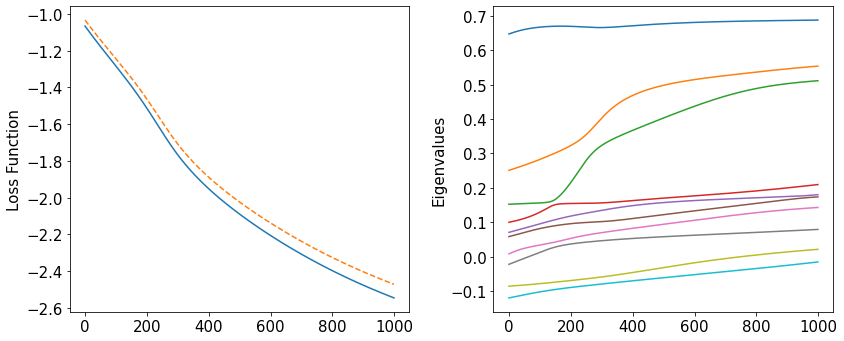

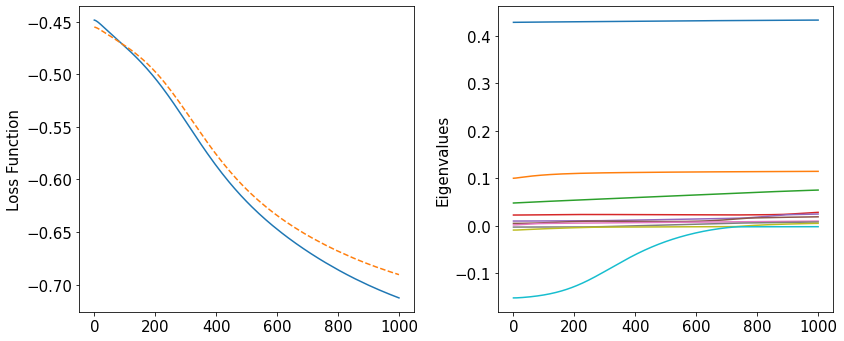

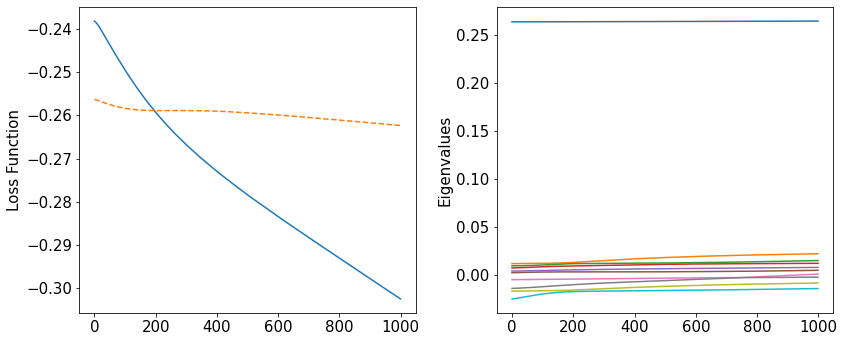

In [33]:
torch.manual_seed(21)
model,data,logweight,X,train_loader,valid_loader = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)
plot_model_lossfunction(model)
for i in [5,10]:
    #reset loss function and evals
    model.loss_train = []
    model.loss_valid = []
    model.evals_train = []
    model.epochs = 0
    #reset earlystopping
    model.set_earlystopping(patience=train_parameters['es_patience'],
                            min_delta=0.,consecutive=train_parameters['es_consecutive'], save_best_model=True, log=False)
    #create dataset given a certain lag time
    dataset = create_time_lagged_dataset(X,t=data["time"].to_numpy(),lag_time=i,logweights=logweight)
    n_train  = int( train_parameters["trainsize"] * len(dataset) )
    n_valid  = len(dataset) - n_train
    train_data, valid_data = random_split(dataset,[n_train,n_valid])
    train_loader = FastTensorDataLoader(train_data, batch_size=len(train_data))
    valid_loader = FastTensorDataLoader(valid_data, batch_size=len(valid_data))
    #train the model
    model.fit(train_loader,valid_loader=valid_loader,
        standardize_inputs=train_parameters['standardize_inputs'],
        standardize_outputs=train_parameters['standardize_outputs'],
        loss_type=train_parameters['loss_type'],
        n_eig=train_parameters['n_eig'],
        nepochs=train_parameters['num_epochs'],
        info=False, log_every=train_parameters['log_every'])
    #plot loss function
    plot_model_lossfunction(model)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())

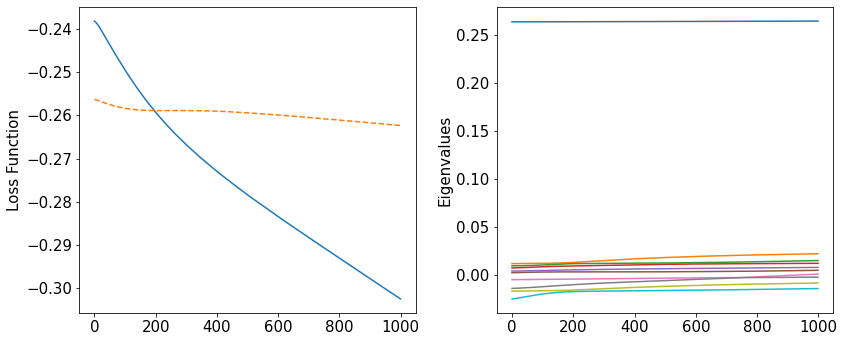

In [27]:
plot_model_lossfunction(model)

In [28]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

<AxesSubplot:ylabel='Frequency'>

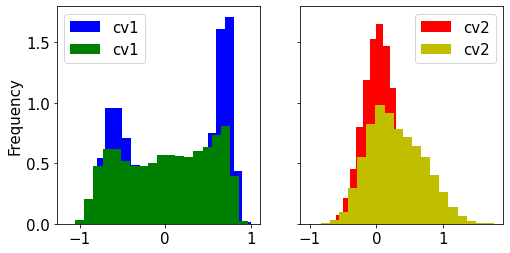

In [29]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="g")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="y")

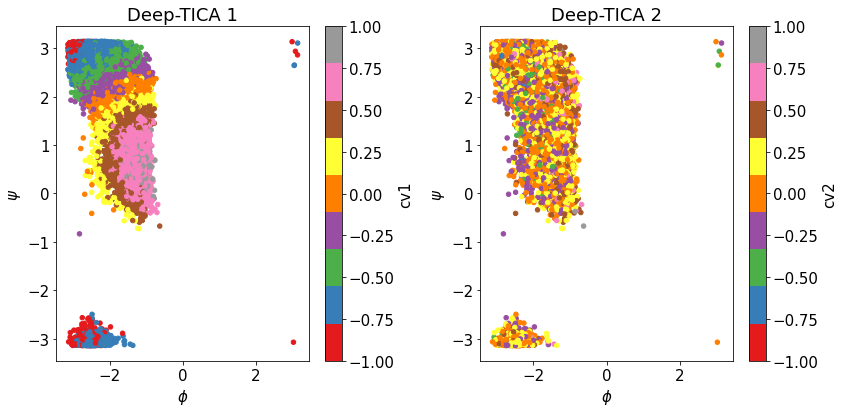

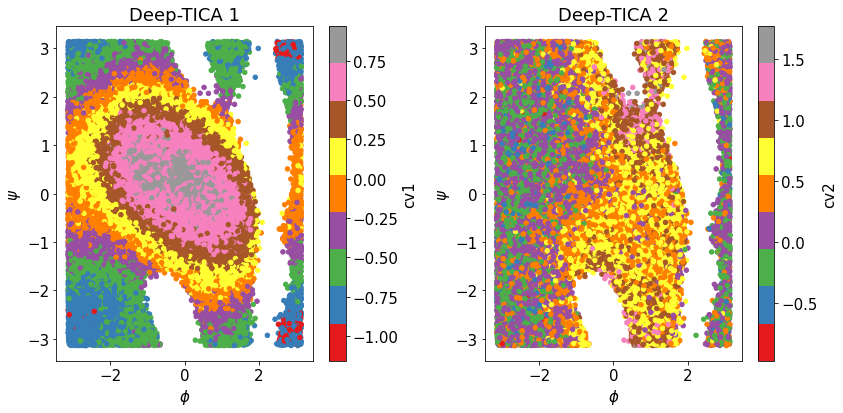

In [30]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

In [24]:
Boltzmann_product(model,model,X,j=0,k=1)

-0.00016780901995798467

# $\tau = 1$ 

## DeepTICA Analysis and Export

In [ ]:
torch.manual_seed(21)
model,data,logweight,X,train_loader,valid_loader = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())

In [ ]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [ ]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="g")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="y")

In [ ]:
fes_1d(data_complete,sim_parameters)

In [ ]:
#fes_2d(data_complete,sim_parameters)

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

In [ ]:
fig,axs = plt.subplots(2,1,figsize=(16,12),sharex=True)
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
    corr = data[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35, color="b",label=r"$C(deep|desc)$")
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [ ]:
Boltzmann_product(model,model,X,j=0,k=1)

# $\tau = 10$

## DeepTICA Analysis and Export

In [ ]:
train_parameters["lag_time"] = 10
torch.manual_seed(21)
model,data,logweight,X,train_loader,valid_loader = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())

In [ ]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [ ]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="g")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="y")

In [ ]:
fes_1d(data_complete,sim_parameters)

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

In [ ]:
fig,axs = plt.subplots(2,1,figsize=(16,12),sharex=True)
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
    corr = data[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35, color="b",label=r"$C(deep|desc)$")
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [ ]:
Boltzmann_product(model,model,X,j=0,k=1)

# $\tau = 100$

## DeepTICA Analysis and Export

In [ ]:
train_parameters["lag_time"] = 100
torch.manual_seed(21)
model,data,logweight,X,train_loader,valid_loader = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())

In [ ]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [ ]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="g")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="y")

In [ ]:
fes_1d(data_complete,sim_parameters)

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

In [ ]:
fig,axs = plt.subplots(2,1,figsize=(16,12),sharex=True)
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
    corr = data[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35, color="b",label=r"$C(deep|desc)$")
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [ ]:
Boltzmann_product(model,model,X,j=0,k=1)

# $\tau = 500$

## DeepTICA Analysis and Export

In [ ]:
train_parameters["lag_time"] = 500
torch.manual_seed(21)
model,data,logweight,X = training(sim_parameters["beta"],folder+"COLVAR",train_parameters)

#-- move the model back to cpu for convenience --# 
model.to('cpu')

#-- print some useful results --#
print("timescales: ",model.tica.timescales(train_parameters["lag_time"]).detach().cpu().numpy()) 
print("eigenvalues: ",model.tica.evals_.detach().cpu().numpy())

In [ ]:
plot_model_lossfunction(model)

#### Adding to data the cvs values

In [ ]:
data["cv1"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[0]
data["cv2"] = np.transpose(model(torch.Tensor(X)).detach().cpu().numpy())[1]
data_complete["cv1"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[0]
data_complete["cv2"] = np.transpose(model(torch.Tensor(X_complete)).detach().cpu().numpy())[1]

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(8,4),sharey=True)
data.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="b")
data.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="r")
data_complete.plot.hist(y="cv1",bins=20,ax=axs[0],density=True,color="g")
data_complete.plot.hist(y="cv2",bins=20,ax=axs[1],density=True,color="y")

In [ ]:
fes_1d(data_complete,sim_parameters)

We can also plot the correlation (*Pearson* correlation ,which simply means normed correlation) of the Deep-TICA cvs with the descriptors

In [ ]:
fig,axs = plt.subplots(2,1,figsize=(16,12),sharex=True)
for k,cv in enumerate(["cv1","cv2"]):
    cols = [cv]
    cols.extend(data.filter(regex=train_parameters["descriptors"]).columns)
    corr = data[cols].corr(method='pearson')
    corr[cv].drop(cv).plot(kind='bar', ax=axs[k], rot=35, color="b",label=r"$C(deep|desc)$")
    axs[k].set_title('Correlation with DeepTICA '+str(k+1))
plt.show()

In [ ]:
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()
fig,axs = plt.subplots(1,2,figsize=(12,6))
for k,ax in enumerate(axs):
    data_complete.plot.scatter(y="psi",x="phi",c="cv"+str(k+1),cmap="Set1",ax=ax)
    ax.set_xlabel(r"$\phi$")
    ax.set_ylabel(r"$\psi$")
    ax.set_title('Deep-TICA '+str(k+1))
plt.tight_layout()

### Orthogonality  
We said that the **ICs** must satisfy two conditions. The first one is that they are uncorrelated, which means that $\int d \vec x \psi_1(\vec x) \psi_2(\vec x) e^{-\beta U(\vec x)} = 0$.  
But their scalar product on the data will lead to a slightly different result, in this case approximately $0$, but not perfectly $0$

In [ ]:
Boltzmann_product(model,model,X,j=0,k=1)